<a href="https://colab.research.google.com/github/visiont3lab/deep-learning-course/blob/main/colab/SemanticSegmentationExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Get Background Images

In [1]:
# Get background images from arcolinux github
!git clone https://github.com/arcolinux/arcolinux-wallpapers.git
!mv arcolinux-wallpapers/usr/share/backgrounds/arcolinux backgrounds
!rm -rf arcolinux-wallpapers

Cloning into 'arcolinux-wallpapers'...
remote: Enumerating objects: 274, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 274 (delta 26), reused 67 (delta 13), pack-reused 193
Receiving objects: 100% (274/274), 133.35 MiB | 17.50 MiB/s, done.
Resolving deltas: 100% (71/71), done.


## Get images person


In [4]:
# Collect images and place them inside test folder
!mkdir -p test

In [5]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [8]:
!mv photo.jpg test/1.jpg

## Run Model

Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth


  0%|          | 0.00/42.3M [00:00<?, ?B/s]

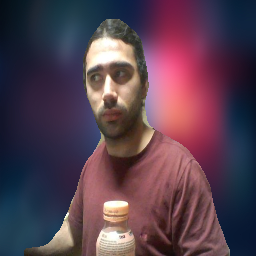

In [9]:
import os
import cv2
import torch
from torchvision import transforms as tr 
import torchvision
import numpy as np
import os

folder_path = "test"
names = os.listdir(folder_path)

classes = ['__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

idx = 0
for i in range(0,len(classes)):
  if classes[i] == "person":
    idx = i
    break

model = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True, progress= True, num_classes= 21)
model.eval()

t = tr.Compose([
            tr.ToPILImage(),
            #tr.Resize((256,256)),
            tr.ToTensor(), # 0-1
            tr.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
for name in names:
  # Leggo un immagine che voglio processare
  filename = os.path.join(folder_path,name)
  im = cv2.imread(filename, cv2.IMREAD_COLOR) # BGR
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))

  # Scelgo un background a caso
  names_background = os.listdir("backgrounds")
  id = np.random.randint(0,len(names_background))
  fbackrground = os.path.join("backgrounds", names_background[id])
  im_background = cv2.imread(fbackrground, cv2.IMREAD_COLOR) # BGR
  im_background = cv2.cvtColor(im_background, cv2.COLOR_BGR2RGB)
  im_background = cv2.resize(im_background,(256,256))
  #display(tr.ToPILImage()(im_background))

  # Setup model
  im_t = t(im) # numero di sample xnumero di canali x h x w
  im_t = im_t.unsqueeze(0)

  # Inference (esecuzione del modello)
  with torch.no_grad():
    res = model(im_t)
    #print("Keys result: ", res.keys())
    #print(res["out"].shape)
    output_t = torch.argmax(res["out"],axis=1) # 1,256,256
    
    # Computer vision
    output = np.uint8(output_t[0].numpy())
    #output[output==idx] = 255
    #display( tr.ToPILImage()(output) )
    kernel = np.ones((5, 5), np.uint8)
    output = cv2.erode(output, np.ones((5, 5), np.uint8)) 
    output = output[:,:,np.newaxis]
    mask = np.repeat(output, 3, axis=-1)
    
    im_background[mask==idx] = im[mask==idx] # persona = 15
    display(tr.ToPILImage()(im_background))
   
    # Modello

  #display(im_vis)


## Export Onnx Model

In [ ]:
# define input size
model_h,model_w = (256,256)
B,C,H,W = 1,3,model_h,model_w
input = torch.randn(B, C, H, W)

# It's optional to label the input and output layers
#input_names = [ "actual_input_1" ] + [ "learned_%d" % i for i in range(16) ]
#output_names = [ "output1" ]

# Use the exporter from torch to convert to onnx 
# model (that has the weights and net arch)
#torch.onnx.export(model, input, "deeplabv3_resnet50.onnx", verbose=True, input_names=input_names, output_names=output_names, opset_version=11)
torch.onnx.export(model, input, "deeplabv3_resnet50.onnx", verbose=True, opset_version=11)

## Run with onnx

In [11]:
!pip install onnxruntime

input name input.1
input shape [1, 3, 256, 256]
input type tensor(float)
output name 615
output shape [1, 21, 256, 256]
output type tensor(float)


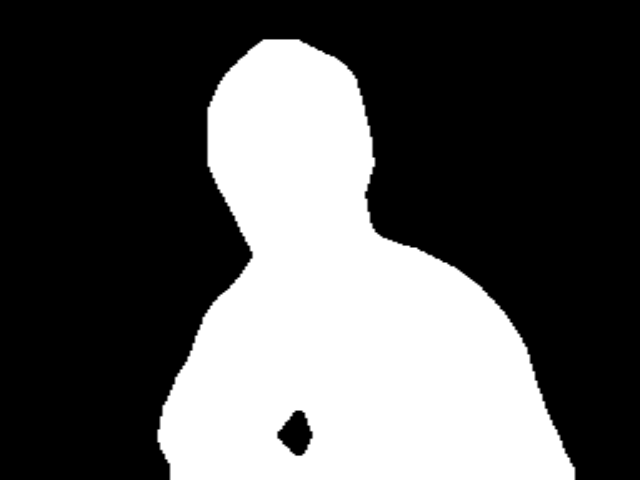

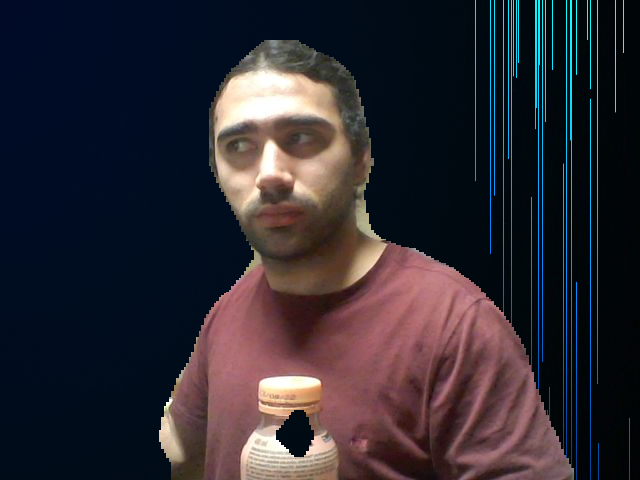

In [18]:
import onnxruntime as rt
import numpy as np
import cv2
from PIL import Image

class SegmentationInference:

    def __init__(self,path2model):
        self.sess = rt.InferenceSession(path2model)
        self.input_name = self.sess.get_inputs()[0].name
        self.input_shape = self.sess.get_inputs()[0].shape
        self.h = self.input_shape[2]
        self.w = self.input_shape[3]
        self.input_type = self.sess.get_inputs()[0].type
        self.output_name = self.sess.get_outputs()[0].name
        self.output_shape = self.sess.get_outputs()[0].shape
        self.output_type = self.sess.get_outputs()[0].type 

    def print_model_info(self):
        # Input informations
        print("input name", self.input_name)
        print("input shape", self.input_shape)
        print("input type", self.input_type)
        # Outpout informations
        print("output name", self.output_name)
        print("output shape", self.output_shape)
        print("output type", self.output_type)

    def predict(self, x):
        x = cv2.resize(x, (self.w,self.h))
        x = x.astype(np.float32)/255.0 #[0-1]
        mean = np.array([0.485, 0.456, 0.406],dtype=np.float32)
        std = np.array([0.485, 0.456, 0.406],dtype=np.float32)
        x = x - mean
        x = x / std
        x = np.transpose(x, (2, 0, 1) ) # BCHW
        x = x[np.newaxis,:,:,:]
        res = self.sess.run([self.output_name], {self.input_name: x})[0]
        res = np.argmax(res, axis=1)[0]
        return res

    def replace_background(self,frame,background,idx):
        # Resize
        h = frame.shape[0]
        w = frame.shape[1]
        background = cv2.resize(background, (w,h))
        
        # Predict
        output = self.predict(frame)
        #print(output.shape,frame.shape,background.shape)
        
        # Select person
        mask = np.zeros(output.shape, dtype=np.uint8)
        mask[output == idx] = 255  # mask 0-1
        if idx == 0: # background
            mask = cv2.bitwise_not(mask)
        if len(mask.flatten()==255)>20:
            # Erosion
            kernel = np.ones((3,3), np.uint8)
            mask = cv2.erode(mask, kernel) 
        mask = cv2.resize(mask, (w,h))
        mask = np.repeat(mask[:, :, np.newaxis], 3, axis = 2)
        display(Image.fromarray(mask))

        # Replace background
        background[mask==255] = frame[mask==255]
        #display(to_pil_image(background))

        return background

# Read Model
path2model = "deeplabv3_resnet50.onnx"
segInf = SegmentationInference(path2model)
segInf.print_model_info()

# Read frame
names = os.listdir("test")
frame = cv2.imread("test"+"/"+names[0],1)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Read background
names = os.listdir("backgrounds")
h,w,c = frame.shape
background = cv2.imread("backgrounds"+"/"+names[0],1)
background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
background = cv2.resize(background, (w,h) )

# Replace background
background = segInf.replace_background(frame,background,idx=15)
display( Image.fromarray(background) )